# 1. Подготовка данных

In [1]:
# загрузка библиотеки
# (1) для осуществления операций с массивом данных
import pandas as pd
# (2) для построения диаграмм
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# изменение тем графического построения
plt.style.use('ggplot')
sns.set_style('darkgrid')
# загрузка метрик: (a) F1, (б) ROC-кривая, (в) площадь по ROC-кривой
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
# загрузка метода, позволяющего стандартизировать наблюдения
from sklearn.preprocessing import StandardScaler
# загрузка модели случайного леса
from sklearn.ensemble import RandomForestClassifier
# загрузка метода, позводяющего разделить выборочную совокупность
from sklearn.model_selection import train_test_split
# загрузка метода, позволяющего перемешать наблюдения
from sklearn.utils import shuffle
# загрузка модуля для фиксирования времени
import time

In [2]:
start_project_time = time.time()

In [3]:
# загрузка массива статистических данных
churn = pd.read_csv('Churn.csv')

In [4]:
# вывод первых 5-ти наблюдений выборочной совокупности
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
# Вывод общей информации о переменных выборочной совокупности
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Таким образом, выборочная совокупность состоит из 10 000 клиентов банка "Бета-Банк". По каждому клиенту имееются следующие показатели (в скобках указан тип переменной):
- RowNumber — индекс строки в данных (целочисленный формат)
- CustomerId — уникальный идентификатор клиента (целочисленный формат)
- Surname — фамилия (строковый формат)
- CreditScore — кредитный рейтинг (целочисленный формат)
- Geography — страна проживания (строковый формат)
- Gender — пол (строковый формат)
- Age — возраст (целочисленный формат)
- Tenure — количество недвижимости у клиента (формат с плавающей точкой)
- Balance — баланс на счёте (формат с плавающей точкой)
- NumOfProducts — количество продуктов банка, используемых клиентом (целочисленный формат)
- HasCrCard — наличие кредитной карты (целочисленный формат)
- IsActiveMember — активность клиента (целочисленный формат)
- EstimatedSalary — предполагаемая зарплата (формат с плавающей точкой)

Целевым признаком является:
- Exited — факт ухода клиента (целочисленный формат)

По переменной, отражающей количество недвижимости у клиента Tenure имеются 9091 наблюдения из 10 000. Возможные причины пропуска: (1) у клиента действительно нет официальных документов, подтверждающих наличие недвижимости: например, клиент может проживать на съемной квартире, (2) недвижимость может быть оформлена не на него лично, а на близких людей.

Стоит отметить, что индекс строки RowNumber, уникальный идентификатор CustomerId, фамилия клиента Surname скорее не имеют столь полезной информации в определении вероятности ухода.

In [6]:
# Осуществим подсчет доли уникального количества недвижимости клиентов
churn['Tenure'].value_counts(normalize=True)

1.0     0.104719
2.0     0.104499
8.0     0.102629
3.0     0.102079
5.0     0.101969
7.0     0.101749
4.0     0.097349
9.0     0.097019
6.0     0.096909
10.0    0.049060
0.0     0.042020
Name: Tenure, dtype: float64

Так как имеем клиентов у которых действительно нет недвижимости, то заполнение пропущенных наблюдений по количеству недвижимости нулевыми значениями приведет к смещению результатов в пользу клиентов у которых нет недвижимости.

In [7]:
# Заполним пропущенные наблюдения по количеству недвижимости медианным значением
churn['Tenure'] = churn['Tenure'].fillna(value=churn['Tenure'].median())

In [8]:
# Осуществим подсчет доли уникальных величин переменной, отражающей пол клиента и страну проживания
for feature in ['Gender','Geography']:
    print(feature + ':')
    print(churn[feature].value_counts(normalize=True))
    print()

Gender:
Male      0.5457
Female    0.4543
Name: Gender, dtype: float64

Geography:
France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64



45.43 процента исходной выборочной совокупности составляют клиенты женского пола, 54.57 процентов являются клиентами мужского пола. Далее, преобразуем пол Gender в индикаторные переменные. Половина клиентов проживают во Франции.

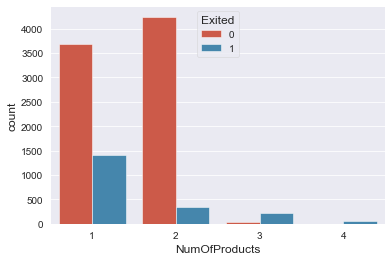

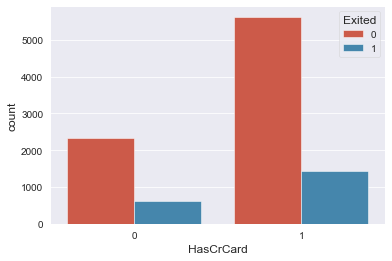

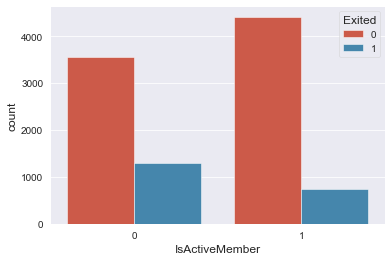

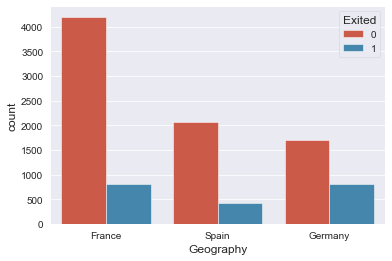

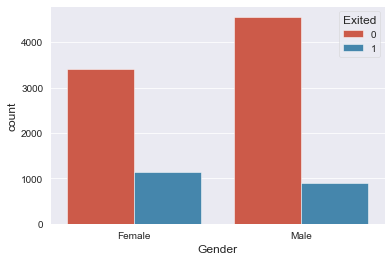

In [9]:
# Через цикл for для переменных, которые отражают
# (1) количество продуктов банка, используемые клиентом, (2) наличие кредитной карты, (3) активности клиента,
# (4) страны проживания, (5) гендерного признака клиента
for feature in ['NumOfProducts','HasCrCard','IsActiveMember','Geography','Gender']:
    # построим столбиковые диграммы, иллюстрирующие количество фактов ухода из банка
    sns.countplot(x=feature, hue='Exited', data=churn)
    # вывод соответствующих диаграмм
    plt.show()

- чем б*о*льшим количеством продуктов банка пользуется клиент, тем менее вероятно не будет пользоваться услугами банка
- отсутствие кредитной карты повышает вероятность ухода из банка
- активность клиента снижает вероятность ухода из банка
- наименьшая доля оттока клиентов наблюдается во Франции, наибольшая - в Германиии
- чаще услугами банка перестают пользоваться женщины по сравнению с мужчинами

In [10]:
# Вычислим среднее значение предполагаемой заработной платы
mean_est_salary = churn['EstimatedSalary'].mean()
# Вычислим значение третьего квартиля предполагаемой заработной платы
upper_est_salary = churn['EstimatedSalary'].describe()['75%']

# Определим функцию, которая классифицирует клиентов в зависимости от величины предполагаемой заработной платы
def salary_category(salary):
    '''
    salary: предполагаемая заработная плата
    output: классификация клиентов в зависимости от предполагаемой заработной платы
    '''
    # Если преполагаемая заработная плата меньше средней величины,
    if salary < mean_est_salary:
        # то классифируем клиента в категорию "низкой зарплаты"
        return 'low_salary'
    # Если предполагаемая заработная плата (а) не меньше средней величины, (б) меньше третьего квартиля, то
    elif mean_est_salary <= salary < upper_est_salary:
        # то классифицируем клиента в категорию средней "заработной платы"
        return 'mean_salary'
    # в остальных случаях,
    else:
        # классифицируем клиента в категорию "высокой зарплаты"
        return 'high_salary'

In [11]:
# Сформируем столбец salary_category, в котором отражены три категории клиентов в зависимости от зарплаты
churn['salary_category'] = churn['EstimatedSalary'].apply(salary_category)

In [12]:
# Вычислим среднее значение баланса на счете
mean_balance = churn['Balance'].mean()
# Вычислим значение третьего квартиля баланса на счете
upper_balance = churn['Balance'].describe()['75%']

# Определим функцию, которая классифицирует клиентов в зависимости от величины баланса на счете
def balance_category(balance):
    '''
    balance: баланс на счете
    output: классификация клиентов на три категории в зависимости от величины баланса на счете
    '''
    # Если баланс меньше средней величины, то
    if balance < mean_balance:
        # классифицируем клиента в категорию "низкий баланс"
        return 'low_balance'
    # Если баланс (а) не меньше средней величины и (б) меньше третьего квартиля, то
    elif mean_balance <= balance < upper_balance:
        # классифицируем клиента в категорию "средний баланс"
        return 'mean_balance'
    # В остальных случаях,
    else:
        # классифицируем клиента в категорию "высокий баланс"
        return 'high_balance'

In [13]:
# Сформируем столбец balance_category, в котором отражены три категории клиентов в зависимости от баланса на счете
churn['balance_category'] = churn['Balance'].apply(balance_category)

In [14]:
# Вычислим средний возраст клиентов
mean_age = churn['Age'].mean()
# Вычислим величину третьего квартиля возраста клиентов
upper_age = churn['Age'].describe()['75%']

# Определим функцию, которая классифицирует клиентов в зависимости от возраста
def age_category(age):
    '''
    age: возраст клиента
    output: классификация клиентов на три категории в зависимости от возраста
    '''
    # Если возраст меньше средней величины, то
    if age < mean_age:
        # клиент относится к категории "молодой"
        return 'young_age'
    # Если возраст (а) не меньше средней величины, (б) меньше третьего квартиля, то
    elif mean_age <= age < upper_age:
        # клиент относится к категории "средний возраст"
        return 'middle_age'
    # В остальных случаях, 
    else:
        # клиент относится к категории "старший возраст"
        return 'upper_age'

In [15]:
# Сформируем столбец age_category, в котором отражены категории в зависимости от возраста клиентов
churn['age_category'] = churn['Age'].apply(age_category)

In [16]:
# Методом .get_dummies преобразуем переменные, содержащие индикаторные переменные.
# Для преодоления проблемы мультиколлинеарности удалим первый столбец соответствующих индикаторных переменных.
churn = pd.get_dummies(data=churn,
                       columns=['Gender','Geography','salary_category','balance_category','age_category'],
                       drop_first=True)

In [17]:
# Выделим целевой признак, отражающий факт ухода клиента.
target = churn['Exited']
# Удалим (1) целевой признак, (2) индекс строки, (3) фамилию, (4) уникальный идентификатор клиента.
# Остальные показатели перенесены в матрицу характеристик клиентов features.
features = churn.drop(labels=['Exited','RowNumber','Surname','CustomerId'], axis=1)

In [18]:
# Разделим исходную выборочную совокупность на
# (1) обучающее и (2) валидационное множества.
# 80 процентов приходятся на обучающее множество. 20 процентов - валидационное множество
features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                              test_size=0.2,
                                                                              random_state=42)

In [19]:
# Далее, разделим обучающее множество на
# (1) обучающее и (2) тестовое множества.
# Для сохранения равности размерности валидационного и тестового множеств,
# стоит определить 25 процентов обучающего множества на тестовое множество,
# так как 100 * 0.2 = 20, что соответствует валидационному множеству.
# В свою очередь, 80 * 0.25 = 20 что соответствует тестовому множеству.
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train,
                                                                            test_size=0.25,
                                                                            random_state=42)

In [20]:
# Вывод размерности каждого из 4-х множеств
print('Размерность')
print('(а) Исходного множества:', features.shape)
print('(б) Обучающего множества:', features_train.shape)
print('(в) Валидационного множества:', features_valid.shape)
print('(г) Тестового множества:', features_test.shape)

Размерность
(а) Исходного множества: (10000, 17)
(б) Обучающего множества: (6000, 17)
(в) Валидационного множества: (2000, 17)
(г) Тестового множества: (2000, 17)


Действительно, соблюдается равенство размерности валидационного и тестового множеств.

Далее, перейдем к стандартизации наблюдений.

In [21]:
# Выделим наименования столбцов, формат которых является (а) целочисленным int64, (б) с плавающей точкой float64
numeric_features = features.select_dtypes(include=['int64','float64']).columns

In [22]:
# Вывод наименования столбцов, формат которых является (а) целочисленным int64, (б) с плавающей точкой float64
numeric_features

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [23]:
# Инициализация метода стандартизирования наблюдений.
scaler = StandardScaler()
# Подгонка метода стандартизации наблюдений по обучающему множеству
scaler.fit(features_train[numeric_features])

StandardScaler()

In [24]:
# Преобразование наблюдений
# (i) обучающего множества
features_train[numeric_features] = scaler.transform(features_train[numeric_features])
# (ii) валидационного множества
features_valid[numeric_features] = scaler.transform(features_valid[numeric_features])
# (iii) тестового множества
features_test[numeric_features] = scaler.transform(features_test[numeric_features])

/home/urma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/urma/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Промежуточные выводы
- Выборочная совокупность составляет 10 000 клиентов банка "Бета-Банк". По каждому из клиентов имеются 13 показателей, отражающие социальное, экономическое, географическое, демографическое положения  и 1 целевой признак, отражающий факт ухода из банка.
- Характеристики, отражающие пол преобразованы в индикаторные переменные.
- В матрицу характеристик клиентов не включены (1) индекс строки, (2) фамилия, (3) уникальный идентификатор клиентов.
- 60, 20, 20 процентов исходной выборочной совокупности разделены на обучающее, валидационное и тестовое множества, соответственно.
- Определили категории клиентов в зависимости от (а) предполагаемой заработной платы, (б) баланса на счете, (в) возраста.
- Наблюдения с целочисленным форматом int64 и форматом с плавающей точкой float64 приведены к наблюдениям с нулевым средним $\mu=0$ и единичным стандартным отклонением $\sigma=1$.

# 2. Исследование задачи

In [25]:
# Подсчет доли клиентов согласно факту ухода
churn['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

- 20.37 процентов индивидов уже не являются клиентами Бета-банка.
- 79.63 процента индивидов продолжают пользоваться услугами Бета-банка.

Впоследствии, воспользуемся тремя методами преодоления дисбаланса целевого признака: (1) указание в аргументе class_weight=='balanced' моделей cлучайного леса, (2) приравнивание размерности выборки с единичными целевыми признаками к нулевым, т.е. upsample, (3) приравнивание размерности выборки с нулевыми целевыми признаками к единичным, т.е. downsample.

Далее, обучим модель случайного леса в зависимости от максимальной глубины max_depth и количества деревьев n_estimators.

In [26]:
# В контексте несбалансированного валидационного множества определим листы, значениями которых будут
# (а) метрики f1
f1_valid_unbalance = []
# (б) площадь под ROC-кривой
auc_roc_valid_unbalance = []
# (в) глубина деревьев
max_depth_unbalance = []
# (г) количество деревье
n_estimators_unbalance = []

# начало времени обучения
start_unbalance = time.time()
# Через цикл for
# (1) определим максимальную длину случайного леса, в частности от 30 до 35 с шагом 5
for depth in range(30,36,5):
    # (2) и количество деревьев от 100 до 310 с шагом 10
    for estimate in range(100,311,10):
        # (3) построим модели случайного леса в зависимости от глубины и количества деревьев 
        # при этом задействуем все процессоры
        forest_unbalance = RandomForestClassifier(random_state=42, max_depth=depth,
                                                  n_estimators=estimate, n_jobs=-1)
        # (4) обучим модели случайного леса на тренировочном множестве
        forest_unbalance.fit(features_train, target_train)
        # (5) определим вероятность ухода клиента на валидационном множестве
        predicted_valid_unbalance = forest_unbalance.predict(features_valid)
        # (6) аналогично, определим вероятность ухода клиента
        pred_prob_valid_unbalance = forest_unbalance.predict_proba(features_valid)
        # (7) выделим вероятность принадлежности к классу 1
        pred_prob_one_valid_unbalance = pred_prob_valid_unbalance[range(len(pred_prob_valid_unbalance)) ,1]
        # (8) вычислим метрику f1 в контексте валидационного множества
        f1_valid_unbalance.append(f1_score(target_valid, predicted_valid_unbalance))
        # (9) вычислим площадь под ROC-кривой
        auc_roc_valid_unbalance.append(roc_auc_score(target_valid, pred_prob_one_valid_unbalance))
        # (10) зафиксируем глубину деревьев
        max_depth_unbalance.append(depth)
        # (11) зафиксируем количество деревьев
        n_estimators_unbalance.append(estimate)

# Конец времени обучения
end_unbalance = time.time()
print('Время обучения на валидационном мн-ве: {:.4f} секунд'.format(end_unbalance - start_unbalance))

Время обучения на валидационном мн-ве: 42.6274 секунд


In [27]:
# Сформируем базу данных, у которого
# (а) столбец f1_score отражает метрику f1,
# (б) столбец auc_roc_score отражает площадь под ROC-кривой
# (в) столбец max_depth_ отражает глубину деревьев
# (г) столбец n_estimators отражает количество деревьев леса
metrics_unbalance = pd.DataFrame({'f1_score':f1_valid_unbalance,
                                  'auc_roc_score': auc_roc_valid_unbalance,
                                  'max_depth': max_depth_unbalance,
                                  'n_estimators': n_estimators_unbalance})

In [28]:
# Определим функцию plot_metrics, которая строит графическую иллюстрацию метрики
def plot_metrics(dataframe, metrics, style=['g+-'], threshold=None):
    '''
    dataframe: массив со значениями метрик f1_score, auc_roc_score
    metrics: метрика (например, f1_score, auc_roc_score)
    style: стиль построения значений метрики
    threshold: пороговый уровень
    output: графическая иллюстрация указанной метрики
    '''
    # Определение фигуры для диаграммы
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,5))
    # Построение указанной метрики
    dataframe[metrics].plot(ax=axes, style=style, legend=True)
    
    axes.set_xticks(dataframe.index)
    # Определим метки для оси ОХ, где первая метка - глубина деревьев, вторая метка - количество деревьев в лесу
    axes.set_xticklabels(zip(dataframe['max_depth'], dataframe['n_estimators']), rotation=60)
    # Определим подпись для оси ОХ
    axes.set_xlabel('(max_depth, n_estimators)')
    # Определим подпись для оси ОУ
    axes.set_ylabel(metrics)
    # если указан пороговый уровень, то
    if threshold != None:
        # отображаем указанный порог черной линией
        plt.axhline(y=threshold, lw=3, c='k', label='threshold')
    else:
        pass
    # Отображение легенды
    plt.legend()
    # Сжатие диаграммы
    plt.tight_layout()

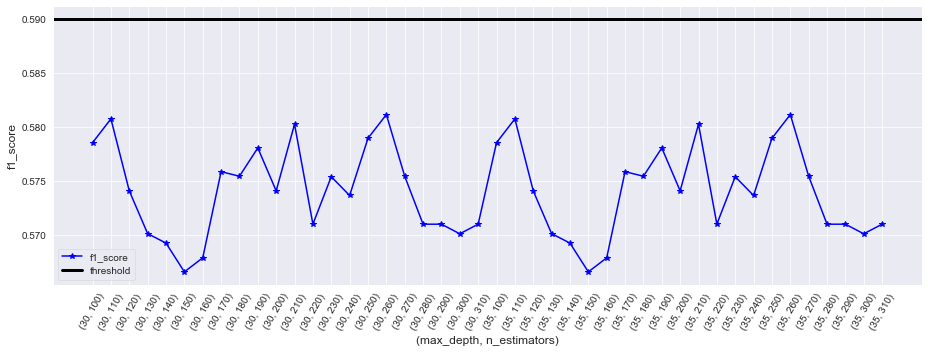

In [29]:
# Построение метрики f1 в контексте несбалансированного вектора целевого признака
plot_metrics(metrics_unbalance,'f1_score',style=['b-*'], threshold=0.59)

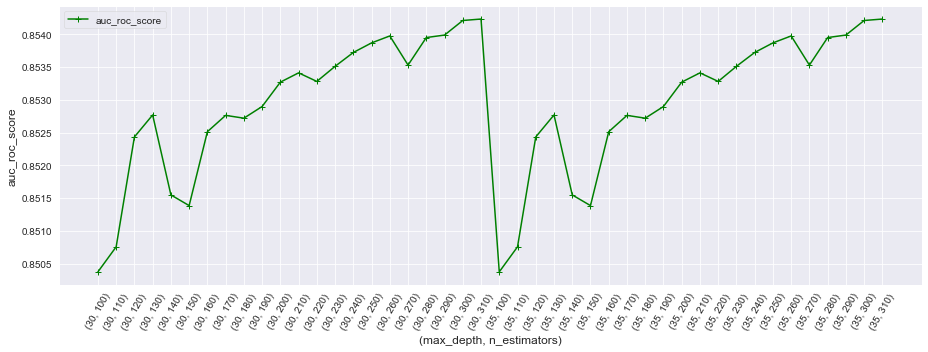

In [30]:
# Построение метрики roc_auc_score в контексте несбалансированного вектора целевого признака
plot_metrics(metrics_unbalance, 'auc_roc_score')

In [31]:
# Определим функцию, которая отображает 5 моделей, по которым наблюдаются наибольшие величины указанных метрик
def top_5_by_metrics(dataframe, metrics):
    '''
    dataframe: массив со значениями метрик f1_score, auc_roc_score
    metrics: метрика (например, f1_score, auc_roc_score)
    output: вывод 5-ти моделей, по которым наблюдаются наибольшие величин метрик указанных в аргументе metrics
    '''
    return dataframe.sort_values(by=[metrics], ascending=False).head(5)

In [32]:
# Вывод 5 моделей, по которым наблюдаются наибольшие величины метрики f1_score
top_5_by_metrics(metrics_unbalance, 'f1_score')

,f1_score,auc_roc_score,max_depth,n_estimators
38,0.581144,0.853975,35,260
16,0.581144,0.853975,30,260
23,0.580745,0.850756,35,110
1,0.580745,0.850756,30,110
11,0.580247,0.853412,30,210


In [33]:
# Вывод 5 моделей, по которым наблюдаются наибольшие величины метрики auc_roc_score
top_5_by_metrics(metrics_unbalance, 'auc_roc_score')

,f1_score,auc_roc_score,max_depth,n_estimators
43,0.570983,0.854233,35,310
21,0.570983,0.854233,30,310
42,0.570093,0.854211,35,300
20,0.570093,0.854211,30,300
41,0.570983,0.853989,35,290


#### Промежуточные выводы
- Около 20-ти процентов индивидов уже не являются клиентами банка "Бета-Банк". Тем самым, в одном случае из 5-ти можно случайным образом правильно определить вероятность ухода индивида.
- Наибольшая величина метрики f1 в размере 0.581 наблюдаются в модели случайного леса с максимальной глубиной деревьев 35 и количеством деревьев 260.
- Наибольшая величина метрики auc_roc_score в размере 0.854 наблюдаются в модели случайного леса с максимальной глубиной деревьев 35 и количеством деревьев 310.

# 3. Борьба с дисбалансом

Ранее, мы узнали, что 20 процентов индивидов уже не являются клиентами банка, в то время как остальные 80 процентов продолжают пользоваться услугами банка.

Для преодоления дисбаланса целевого признака воспользуемся (1) указанием баланса в аргументе моделей случайного леса, (2) downsample, (3) upsample.

#### (1) Указание balance в аргументе class_weight в модели случайного леса.

In [34]:
# В контексте сбалансированного валидационного множества определим листы, значениями которых будут
# (а) метрики f1
f1_valid_balance = []
# (б) площадь под ROC-кривой
auc_roc_valid_balance = []
# (в) глубина деревьев
max_depth_balance = []
# (г) количество деревье
n_estimators_balance = []

# Начало времени обучения
start_balance = time.time()
# Через цикл for
# (1) определим максимальную длину случайного леса, в частности от 30 до 36 с шагом 5
for depth in range(30,36,5):
    # (2) и количество деревьев от 10 до 310 с шагом 10 [3*22=66 моделей]
    for estimate in range(100,311,10):
        # (3) построим модели случайного леса в зависимости от глубины и количества деревьев 
        # при этом задействуем все процессоры и учтем баланс целевого признака
        forest_balance = RandomForestClassifier(random_state=42, max_depth=depth, n_estimators=estimate,
                                        n_jobs=-1, class_weight='balanced')
        # (4) обучим модели случайного леса на тренировочном множестве
        forest_balance.fit(features_train, target_train)
        # (5) определим вероятность ухода клиента на валидационном множестве
        predicted_valid_balance = forest_balance.predict(features_valid)
        # (6) аналогично, определим вероятность ухода клиента
        pred_prob_valid_balance = forest_balance.predict_proba(features_valid)
        # (7) выделим вероятность принадлежности индивида к классу 1
        pred_prob_one_valid_balance = pred_prob_valid_balance[range(len(pred_prob_valid_balance)), 1]
        # (8) вычислим метрику f1 в контексте валидационного множества
        f1_valid_balance.append(f1_score(target_valid, predicted_valid_balance))
        # (9) вычислим площадь под ROC-кривой
        auc_roc_valid_balance.append(roc_auc_score(target_valid, pred_prob_one_valid_balance)) 
        # (10) зафиксируем глубину деревьев
        max_depth_balance.append(depth)
        # (12) зафиксируем количество деревье
        n_estimators_balance.append(estimate)
        
# Конец времени обучения
end_balance = time.time()
print('Время обучения на сбалансированном мн-ве: {:.4f} секунд'.format(end_balance - start_balance))

Время обучения на сбалансированном мн-ве: 47.3225 секунд


In [35]:
# Формирование базы данных, в которой отражены величины метрик f1_score и площади под ROC-кривой auc_roc_score
# с указанием максимальной глубины max_depth и количества деревьев n_estimators сбалансированного случайного леса
metrics_balance = pd.DataFrame({'f1_score':f1_valid_balance,
                                 'auc_roc_score':auc_roc_valid_balance,
                                 'max_depth':max_depth_balance,
                                 'n_estimators':n_estimators_balance})

Воспользуемся вторым методом преодоления дисбаланса.

#### (2) Сокращение размерности выборки с преобладающим количеством величин целевого признака.

In [36]:
# Определим функцию downsample, которая
# случайным образом отбирает указанную долю выборки с преобладающим количеством величин целевого признака.
# В частности, сокращаем выборку индивидов, которые еще являются клиентами банка.
def downsample(features, target, fraction):
    '''
    features: массив данных, содержащий характеристики клиентов
    target: массив данных целевого признака
    fraction: доля выборки с преобладающим количеством величин целевого признака для соблюдения равенства
    размерностей выборок с нулевыми и единичными значениями целевого признака
    ------
    output: (1) features_downsampled: усеченная выборка, (2) target_downsampled: усеченный вектор целевого признака
    '''
    # Массив характеристик, у которых целевой признак является нулевым
    features_zeros = features[target == 0]
    # Массив характеристик, у которых целевой признак равен единице
    features_ones = features[target == 1]
    # Вектор значений с нулевым целевым признаком
    target_zeros = target[target == 0]
    # Вектор значений с единичным целевым признаком
    target_ones = target[target == 1]
    # Соединение (1) усеченной выборки с преобладающим количеством целевого признака,
    # (2) исходной выборкой с меньшим количеством целевого признака
    # для массива с характеристиками клиентов
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    # для вектора целевого признака
    target_downsampled = pd.concat(
    [target_zeros.sample(frac=0.25, random_state=42)] + [target_ones])
    # Перемешиваем массив характеристик и вектор целевого признака
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

In [37]:
# Выделям 25 процентов от выборки с преобладающим количеством целевого признака,
# так как 25 процентов от 80 процентов (клиенты которые еще пользуются услугами банка) равно
# 20 (что соответствует размерности выборки клиентов, которые уже не являются клиентами банка).
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [38]:
# Проверим правильность вычислений и рассуждений
target_downsampled.value_counts()

1    1231
0    1192
Name: Exited, dtype: int64

Таким образом, имеем приблизительно равное количество клиентов, которые уже не пользуются услугами банка (1231 индивид) и количество клиентов, которые еще пользуются услугами банка (1192 индивида).

In [39]:
# В контексте усеченного валидационного множества определим листы, значениями которых будут
# (а) метрики f1
f1_valid_downsample = []
# (б) площадь под ROC-кривой
auc_roc_valid_downsample = []
# (в) глубина деревьев
max_depth_downsample = []
# (г) количество деревье
n_estimators_downsample = []

# Начало времени обучения
start_downsample = time.time()
# Через цикл for
# (1) определим максимальную длину случайного леса, в частности от 30 до 40 с шагом 5
for depth in range(30,41,5):
    # (2) и количество деревьев от 100 до 300 с шагом 10 [тем самым 3*22=66 моделей]
    for estimate in range(100,311,10):
        # (3) построим модели случайного леса в зависимости от глубины и количества деревьев 
        # при этом задействуем все процессоры
        forest_downsample = RandomForestClassifier(random_state=42, max_depth=depth,
                                                   n_estimators=estimate, n_jobs=-1)
        # (4) обучим модели случайного леса на тренировочном множестве
        forest_downsample.fit(features_downsampled, target_downsampled)
        # (5) определим вероятность ухода клиента на валидационном множестве
        predicted_valid_downsample = forest_downsample.predict(features_valid)
        # (6) аналогично, определим вероятность ухода клиента
        pred_prob_valid_downsample = forest_downsample.predict_proba(features_valid)
        # (7) выделим вероятность принадлежности индивида к классу 1
        pred_prob_one_valid_downsample = pred_prob_valid_downsample[range(len(pred_prob_valid_downsample)), 1]
        # (8) вычислим метрику f1 в контексте валидационного множества
        f1_valid_downsample.append(f1_score(target_valid, predicted_valid_downsample))
        # (9) вычислим площадь под ROC-кривой
        auc_roc_valid_downsample.append(roc_auc_score(target_valid, pred_prob_one_valid_downsample))
        # (10) зафиксируем глубину деревьев
        max_depth_downsample.append(depth)
        # (11) зафиксируем количество деревье
        n_estimators_downsample.append(estimate)

# Конец времени обучения
end_downsample = time.time()
print('Время обучения на усеченном мн-ве: {:.4f} секунд'.format(end_downsample - start_downsample))

Время обучения на усеченном мн-ве: 60.4837 секунд


In [40]:
# Сформируем базу данных, у которого
# (а) столбец f1_score отражает метрику f1,
# (б) столбец auc_roc_score отражает площадь под ROC-кривой
# (в) столбец max_depth отражает глубину деревьев
# (г) столбец n_estimators отражает количество деревьев леса
metrics_downsample = pd.DataFrame({'f1_score':f1_valid_downsample,
                                  'auc_roc_score': auc_roc_valid_downsample,
                                  'max_depth': max_depth_downsample,
                                  'n_estimators': n_estimators_downsample})

Воспользуемся третьим методом преодоления дисбаланса.

#### (3) Увеличение размерности выборки с недостающим количеством величин целевого признака.

In [41]:
# Определим функцию upsample, которая увеличивает выборку с наименьшим количеством величин целевого признака.
# В частности увеличивается выборка клиентов, которые ушли из банка.
def upsample(features, target, repeat):
    '''
    features: массив данных, содержащий характеристики клиентов
    target: массив данных целевого признака
    repeat: количество раз увеличения выборки с наименьшим количеством величин целевого признака
    ------
    output: (1) features_upsampled: увеличенная выборка, (2) target_upsampled: увеличенный вектор целевого признака
    '''
    # Массив характеристик, у которых целевой признак является нулевым
    features_zeros = features[target == 0]
    # Массив характеристик, у которых целевой признак равен единице
    features_ones = features[target == 1]
    # Вектор значений с нулевым целевым признаком
    target_zeros = target[target == 0]
    # Вектор значений с единичным целевым признаком
    target_ones = target[target == 1]
    # Соединяем (1) исходную выборку с преобладающим числом целевого признака, 
    # (2) увеличенной выборкой с наименьшим числом целевого признака
    # в контексте массива характеристик
    features_upsampled = pd.concat([features_zeros] + [features_ones]*repeat)
    # в контексте вектора целевого признака
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # Перемешиваем наблюдения
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

In [42]:
# Так как исходное соотношение клиентов и ушедших с банка индивидов составляет 4:1, то
# увеличим выборку клиентов, ушедших с банка в 4 раза.
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [43]:
# Подсчет количества клиентов и ушедших с банка индивидов
target_upsampled.value_counts()

1    4924
0    4769
Name: Exited, dtype: int64

Таким образом, имеем 4924 индивида, которые ушли с банка и 4769 индивидов, которые еще являются клиентами банка.

In [44]:
# В контексте валидационного увеличенного множества определим листы, значениями которых будут
# (а) метрики f1
f1_valid_upsample = []
# (б) площадь под ROC-кривой
auc_roc_valid_upsample = []
# (в) глубина деревьев
max_depth_upsample = []
# (г) количество деревье
n_estimators_upsample = []

# Начало времени обучения
start_upsample = time.time()
# Через цикл for
# (1) определим максимальную длину случайного леса, в частности от 30 до 36 с шагом 5
for depth in range(30,36,5):
    # (2) и количество деревьев от 100 до 310 с шагом 10
    for estimate in range(100,311,10):
        # (3) построим модели случайного леса в зависимости от глубины и количества деревьев 
        # при этом задействуем все процессоры
        forest = RandomForestClassifier(random_state=42, max_depth=depth, n_estimators=estimate, n_jobs=-1)
        # (4) обучим модели случайного леса на тренировочном множестве
        forest.fit(features_upsampled, target_upsampled)
        # (5) определим вероятность ухода клиента на валидационном множестве
        predicted_valid_upsample = forest.predict(features_valid)
        # (6) аналогично, определим вероятность ухода клиента
        pred_prob_valid_upsample = forest.predict_proba(features_valid)
        # (7) выделим вероятность принадлежности индивида к классу 1
        pred_prob_one_valid_upsample = pred_prob_valid_upsample[range(len(pred_prob_valid_upsample)), 1]
        # (8) вычислим метрику f1 в контексте валидационного множества
        f1_valid_upsample.append(f1_score(target_valid, predicted_valid_upsample))
        # (9) вычислим площадь под ROC-кривой
        auc_roc_valid_upsample.append(roc_auc_score(target_valid, pred_prob_one_valid_upsample)) ### ошибка
        # (10) зафиксируем глубину деревьев
        max_depth_upsample.append(depth)
        # (11) зафиксируем количество деревье
        n_estimators_upsample.append(estimate)

# Конец времени обучения
end_upsample = time.time()
print('Время обучения на расширенном мно-ве: {:.4f} секунд.'.format(end_upsample - start_upsample))

Время обучения на расширенном мно-ве: 52.3444 секунд.


In [45]:
# Сформируем базу данных, у которого
# (а) столбец f1_score отражает метрику f1,
# (б) столбец auc_roc_score отражает площадь под ROC-кривой
# (в) столбец max_depth отражает глубину деревьев
# (г) столбец n_estimators отражает количество деревьев леса
metrics_upsample = pd.DataFrame({'f1_score':f1_valid_upsample,
                                  'auc_roc_score': auc_roc_valid_upsample,
                                  'max_depth': max_depth_upsample,
                                  'n_estimators': n_estimators_upsample})

In [46]:
# Определяем словарь из матриц с метриками f1, auc_roc_score в контексте 4-х векторов целевого признака
metrics_dict = {'unbalance':metrics_unbalance,'balance':metrics_balance,
                'downsample':metrics_downsample,'upsample':metrics_upsample}

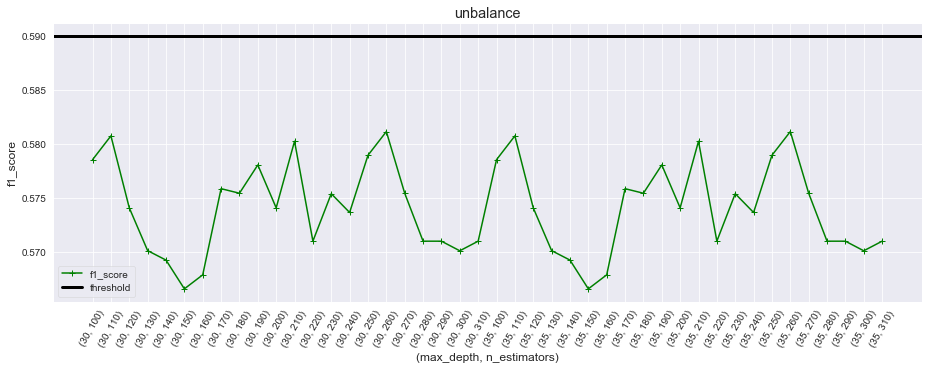

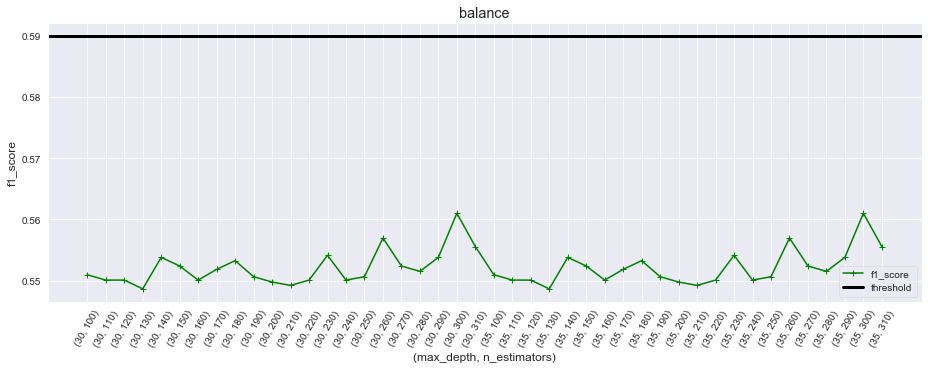

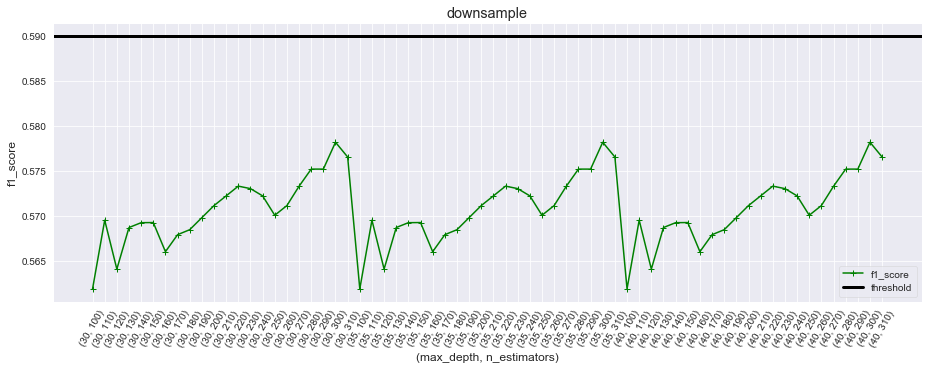

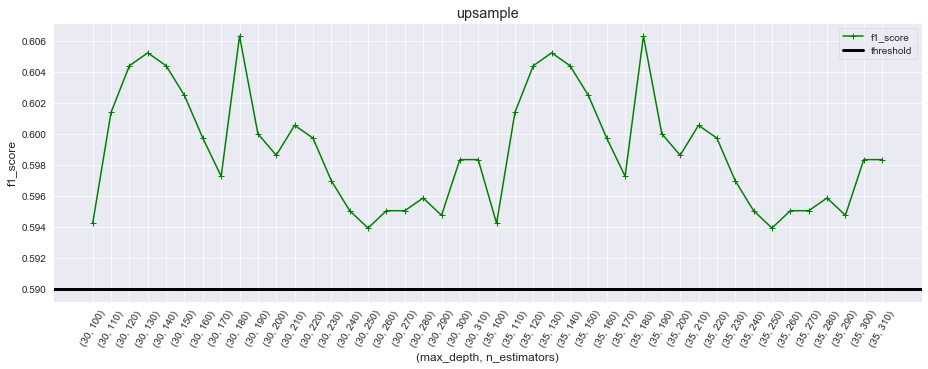

In [47]:
# Построим графическую иллюстрацию метрики f1_score в разрезе 4-х видов пропорций вектора целевого признака
for metrics_label, metrics_dataframe in metrics_dict.items():
    plot_metrics(metrics_dataframe, 'f1_score', threshold=0.59)
    plt.title(metrics_label)
    plt.show()

In [48]:
# Через цикл for
for metrics_label, metrics_dataframe in metrics_dict.items():
    # определим 5 моделей с наибольшей величиной метрики f1 в разрезе 4-х типов векторов целевого признака
    print('*',metrics_label, 'by highest f1_score:')
    print(top_5_by_metrics(metrics_dataframe, 'f1_score'))
    print()

* unbalance by highest f1_score:
    f1_score  auc_roc_score  max_depth  n_estimators
38  0.581144       0.853975         35           260
16  0.581144       0.853975         30           260
23  0.580745       0.850756         35           110
1   0.580745       0.850756         30           110
11  0.580247       0.853412         30           210

* balance by highest f1_score:
    f1_score  auc_roc_score  max_depth  n_estimators
42  0.561014       0.853275         35           300
20  0.561014       0.853275         30           300
38  0.556962       0.854002         35           260
16  0.556962       0.854002         30           260
43  0.555556       0.853033         35           310

* downsample by highest f1_score:
    f1_score  auc_roc_score  max_depth  n_estimators
64  0.578199       0.846582         40           300
20  0.578199       0.846582         30           300
42  0.578199       0.846582         35           300
65  0.576560       0.846350         40           310

In [49]:
# Через цикл for
for metrics_label, metrics_dataframe in metrics_dict.items():
    # определим 5 моделей с наибольшей величиной метрики auc_roc в разрезе 4-х типов векторов целевого признака
    print('*',metrics_label, 'by highest roc_auc_score:')
    print(top_5_by_metrics(metrics_dataframe, 'auc_roc_score'))
    print()

* unbalance by highest roc_auc_score:
    f1_score  auc_roc_score  max_depth  n_estimators
43  0.570983       0.854233         35           310
21  0.570983       0.854233         30           310
42  0.570093       0.854211         35           300
20  0.570093       0.854211         30           300
41  0.570983       0.853989         35           290

* balance by highest roc_auc_score:
    f1_score  auc_roc_score  max_depth  n_estimators
30  0.553259       0.854231         35           180
8   0.553259       0.854231         30           180
38  0.556962       0.854002         35           260
16  0.556962       0.854002         30           260
18  0.551506       0.853899         30           280

* downsample by highest roc_auc_score:
    f1_score  auc_roc_score  max_depth  n_estimators
64  0.578199       0.846582         40           300
42  0.578199       0.846582         35           300
20  0.578199       0.846582         30           300
65  0.576560       0.846350         4

#### Промежуточные выводы

<table border = “1“>
<tr>
<th></th> <th>highest f1_score</th> <th>max_depth</th> <th>n_estimators</th> 
</tr>
<tr>
<td><b>Unbalanced</b></td><td>0.581</td><td>35</td> <td>260</td>
</tr>
<tr>
<td><b>Balanced class_weight</b></td><td>0.573</td><td>35</td> <td>310</td>
</tr>
<tr>
</tr>
<tr>
<td><b>Downsampling</b></td> <td>0.578</td><td>40</td> <td>300</td>
</tr>
<tr>
<td><b>Upsampling</b></td> <td>0.606</td><td>30</td> <td>180</td>
</tr>
</table>

<table border = “3“>
<tr>
<th></th> <th>highest roc_auc_score</th> <th>max_depth</th> <th>n_estimators</th> 
</tr>
<tr>
<td><b>Unbalanced</b></td><td>0.854</td><td>35</td> <td>310</td>
</tr>
<tr>
<td><b>Balanced class_weight</b></td><td>0.855</td><td>35</td> <td>310</td>
</tr>
<tr>
</tr>
<tr>
<td><b>Downsampling</b></td> <td>0.846</td><td>40</td> <td>300</td>
</tr>
<tr>
<td><b>Upsampling</b></td> <td>0.851</td><td>35</td> <td>310</td>
</tr>
</table>

Тем самым, с точки зрения метрики f1 наилучшей является модель случайного леса с параметрами `max_depth=30`, `n_estimators=180` в контексте `upsample`, т.е. увеличения выборки с недостающим количеством целевого признака.

# 4. Тестирование модели

Апробируем наилучшую с точки зрения метрики f1_score модель случайного леса на тестовом множестве.

In [50]:
# Построение наилучше модели случайного леса
forest_test = RandomForestClassifier(random_state=42, max_depth=30, n_estimators=180, n_jobs=-1)

In [51]:
target_test.value_counts()

0    1587
1     413
Name: Exited, dtype: int64

Целесообразность использования метода upsample также подкрепляется тем, что имеет место разрыв в объемах индивидов по целевому признаку.

In [52]:
# Обучение модели на расширенном множестве, т.е. используем метод upsampling для преодоления
forest_test.fit(features_upsampled, target_upsampled)

RandomForestClassifier(max_depth=30, n_estimators=180, n_jobs=-1,
                       random_state=42)

In [53]:
# Прогнозирование вероятности ухода клиента
pred_test = forest_test.predict(features_test)
pred_prob_test = forest_test.predict_proba(features_test)
# Выделение вероятности принадлежности индивидов к классу 1
pred_prob_one_test = pred_prob_test[:,1]

In [54]:
# Вывод метрик f1_score, roc_auc_score в контексте тестового множества
print('На тестовом мн-ве получили f1_score={f1:.4f} и auc_roc={auc:.4f}'\
      .format(f1=f1_score(target_test, pred_test), auc=roc_auc_score(target_test, pred_prob_one_test) ))

На тестовом мн-ве получили f1_score=0.6127 и auc_roc=0.8567


#### Промежуточные выводы
- на тестовом множестве, используя метод `upsampling` в модели случайного леса с параметрами `max_depth=30`, `n_estimators=180` получили `f1_score=0.6127`, `roc_auc_score=0.8567`.

### Общие выводы

<table border = “1“>
<tr>
<th></th> <th>highest f1_score</th> <th>max_depth</th> <th>n_estimators</th> 
</tr>
<tr>
<td><b>Unbalanced</b></td><td>0.581</td><td>35</td> <td>260</td>
</tr>
<tr>
<td><b>Balanced class_weight</b></td><td>0.573</td><td>35</td> <td>310</td>
</tr>
<tr>
</tr>
<tr>
<td><b>Downsampling</b></td> <td>0.578</td><td>40</td> <td>300</td>
</tr>
<tr>
<td><b>Upsampling</b></td> <td>0.606</td><td>30</td> <td>180</td>
</tr>
</table>

<table border = “3“>
<tr>
<th></th> <th>highest roc_auc_score</th> <th>max_depth</th> <th>n_estimators</th> 
</tr>
<tr>
<td><b>Unbalanced</b></td><td>0.854</td><td>35</td> <td>310</td>
</tr>
<tr>
<td><b>Balanced class_weight</b></td><td>0.855</td><td>35</td> <td>310</td>
</tr>
<tr>
</tr>
<tr>
<td><b>Downsampling</b></td> <td>0.846</td><td>40</td> <td>300</td>
</tr>
<tr>
<td><b>Upsampling</b></td> <td>0.851</td><td>35</td> <td>310</td>
</tr>
</table>

- на тестовом множестве, используя метод `upsampling` в модели случайного леса с параметрами `max_depth=30`, `n_estimators=180` получили `f1_score=0.6127`, `roc_auc_score=0.8567`.

Таким образом, удалось получить `f1_score` больше 0.59.